## Base code of timeseries classification using Keras
### using the same code of "https://keras.io/examples/timeseries/timeseries_classification_from_scratch/"

In [26]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics.pairwise
import sklearn

In [27]:
length = 1200
RP_size = 128

X = np.load('/Users/u-kei/Desktop/data/CHF986/RPs_' + str(length) + '_' + str(RP_size) + '.npy')
clean_df = pd.read_excel("/Users/u-kei/Desktop/data/Baseline_suv_chf986.xlsx", sheet_name='Sheet1', header=0)
y = clean_df['state'].values

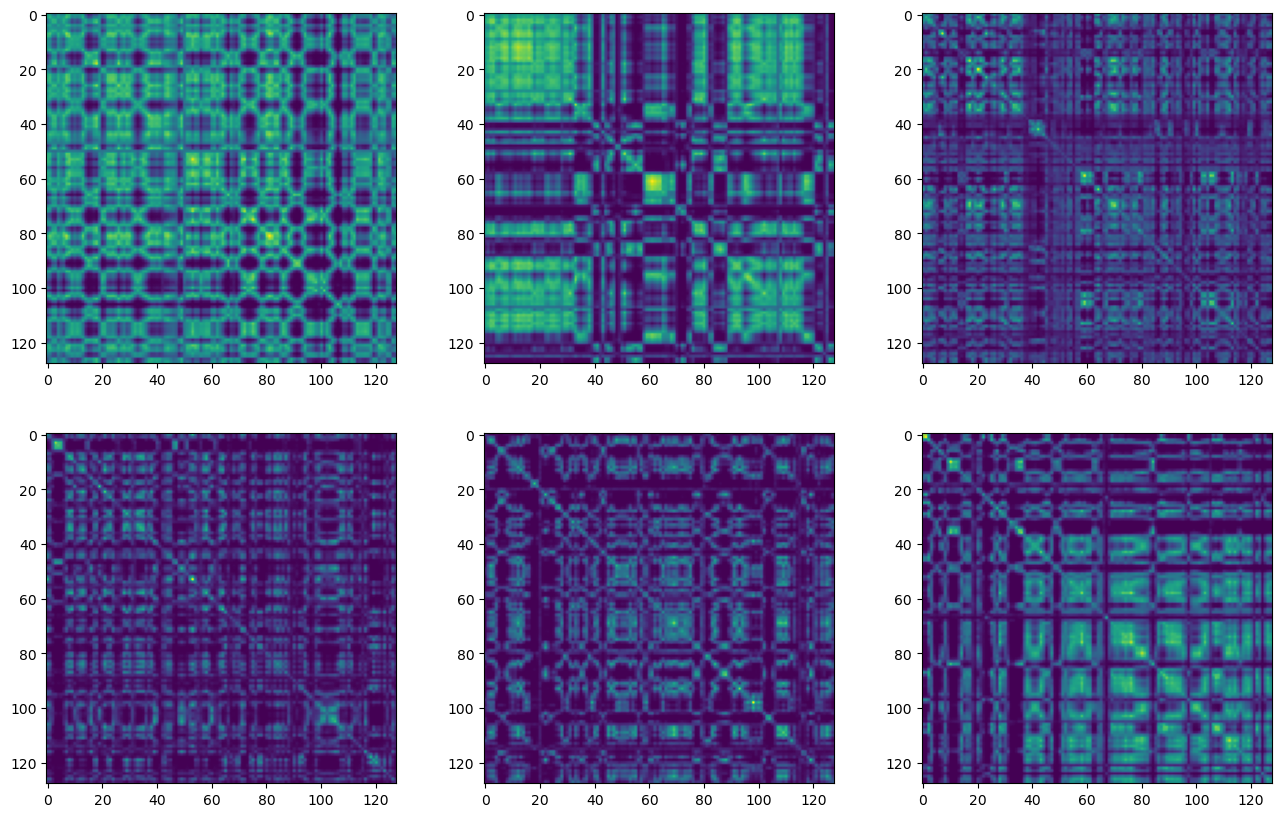

In [28]:
ns_count = np.count_nonzero(y == 1)
sv_count = np.count_nonzero(y == 0)

fig, axes = plt.subplots(2, 3, figsize=(16,10))
for i in range(2):
    for j in range(3):
        axes[i][j].imshow(X[i * ns_count + j, :, :])

In [29]:
N = 5  # cross-validationの回数
batch_size = 16   # バッチサイズ
num_epochs = 200  # エポック数
filters1 = 32
filters2 = 32
kernel = 3
slide = 2
dropout1 = 0.25
dropout2 = 0.25
dropout3 = 0.5
dense = 64

In [30]:
# データをシャッフルする
NN = np.arange(X.shape[0])
NN = np.random.RandomState(seed=10).permutation(NN)   # シャッフル結果が毎回同じになるようにseedを固定

X = X[NN,:,:].astype(np.float32)
y = y[NN]
clean_df = clean_df.iloc[NN,:]

# 日数表示を年数表示に変換
clean_df['year'] = clean_df['day'] / 365.2425

In [31]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters1, (kernel,kernel), activation='relu', input_shape=(1, X.shape[1], X.shape[2]), data_format='channels_first')(input_layer)
    conv1 = keras.layers.MaxPooling2D(slide,slide)(conv1)
    conv1 = keras.layers.Dropout(dropout1)(conv1)

    conv2 = keras.layers.Conv2D(filters2, (kernel,kernel), activation='relu')(conv1)
    conv2 = keras.layers.MaxPooling2D(slide,slide)(conv2)
    conv2 = keras.layers.Dropout(dropout2)(conv2)
    conv2 = keras.layers.Flatten()(conv2)

    conv3 = keras.layers.Dense(dense, activation='relu')(conv2)
    conv3 = keras.layers.Dropout(dropout3)(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(conv3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [32]:
import pprint

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test

from sklearn import metrics

In [33]:
# 左上隅に最も近い点を閾値として採用する
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [34]:
# N回分のカプランマイヤー推定量の保存
calculate_mean_KMcurve_NS = np.zeros([N+1,X.shape[0]])   # N+1番目には平均した結果を格納
calculate_mean_KMcurve_SV = np.zeros([N+1,X.shape[0]])   # N+1番目には平均した結果を格納

# Log-rank検定をN回行い、それぞれのp値を格納していく
p_values = []

# 患者の生存時間をソートした配列を用意
survival_time_sort = np.sort(clean_df['year'].values)

--- 1回目のモデル構築・検証を行います. ---
[197 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437

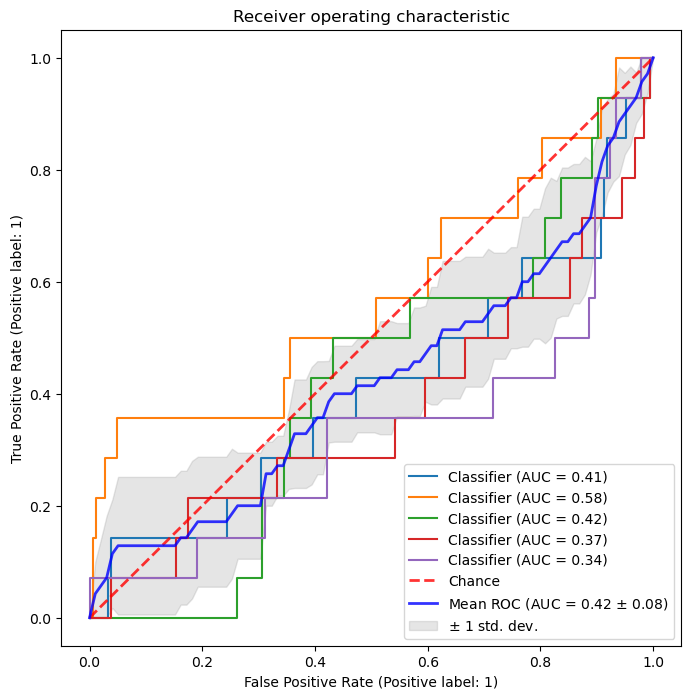

In [35]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

os.chdir(r"/Users/u-kei/Desktop/data/CHF986")   # カレントディレクトリを変更

n_classes = 2
results = []
right_results = []
survival_time = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (8, 8)

# 作ったモデルを入れる配列
model_list = []

# stratifie：クラスの割合が元の標本と同じになるように分割
kf = StratifiedKFold(n_splits=N)

for jj, (train_indexes, test_index) in enumerate(kf.split(X, y)):

  print("--- %d回目のモデル構築・検証を行います. ---" % (jj+1))
  print(train_indexes, test_index)
  X_train = X[train_indexes,:,:]
  y_train = y[train_indexes]
  X_test = X[test_index, :, :]
  y_test = y[test_index]

  # モデルがデータを読み込むには事前にunsqueeze的な作業が必要
  X_train = X_train.reshape(X_train.shape[0], 1, X.shape[1], X.shape[2])
  X_test = X_test.reshape(X_test.shape[0], 1, X.shape[1], X.shape[2])

  model = make_model(input_shape=X_train.shape[1:])
  keras.utils.plot_model(model, show_shapes=True)

  callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
  ]
  model.compile(
      optimizer="adam",
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"],
  )
  history = model.fit(
      X_train,
      y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      callbacks=callbacks,
      validation_split=0.2,
      verbose=1,
  )

  model = keras.models.load_model("best_model.h5") #最もvalidation lossが小さかったものを採用

  test_loss, test_acc = model.evaluate(X_test, y_test)
  print("Test accuracy", test_acc)
  print("Test loss", test_loss)
  
  # modelをリストに保存
  model_list.append(model)
  model_answer = model.predict(X_test)

  for ii in range(model_answer.shape[0]):
    results.append(model_answer[ii,1])
    right_results.append(y_test[ii])
  
  viz = RocCurveDisplay.from_predictions(y_test, model_answer[:,1], ax=ax)
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0

  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)

  # カプランマイヤー推定量の算出
  threshold = Find_Optimal_Cutoff(y_test, model_answer[:,1])
  cnn_stratified = (model_answer[:,1] >=threshold).astype(int)
  ix =  (cnn_stratified == 1)   # highrisk群の位置をixとする
  kmf_high = KaplanMeierFitter()   # highrisk群
  kmf_high.fit(durations=clean_df.iloc[test_index,:]['year'][ix], event_observed=clean_df.iloc[test_index,:]['state'][ix])
  kmf_low = KaplanMeierFitter()   # lowrisk群
  kmf_low.fit(durations=clean_df.iloc[test_index,:]['year'][~ix], event_observed=clean_df.iloc[test_index,:]['state'][~ix])
  # logrank_test
  KMresults = logrank_test(clean_df.iloc[test_index,:]['year'][ix], clean_df.iloc[test_index,:]['year'][~ix],
                       event_observed_A=clean_df.iloc[test_index,:]['state'][ix],
                       event_observed_B=clean_df.iloc[test_index,:]['state'][~ix])
  p_values.append(KMresults.p_value)

  # N個のKM曲線を求め、格納する(for high-risk)
  kmf = kmf_high.survival_function_.values
  aa = 1
  for kk in range(survival_time_sort.shape[0]):
    if survival_time_sort[kk] == kmf_high.timeline[aa]:
      if aa == (kmf.shape[0]-1):
        calculate_mean_KMcurve_NS[jj,kk] = kmf[aa-1]
      else:
        calculate_mean_KMcurve_NS[jj,kk] = (kmf[aa-1] + kmf[aa])/2
        aa = aa+1
    else:
      calculate_mean_KMcurve_NS[jj,kk] = kmf[aa-1]
  # N個のKM曲線を求め、格納する(for low-risk)
  kmf = kmf_low.survival_function_.values
  aa = 1
  for kk in range(survival_time_sort.shape[0]):
    if survival_time_sort[kk] == kmf_low.timeline[aa]:
      if aa == (kmf.shape[0]-1):
        calculate_mean_KMcurve_SV[jj,kk] = kmf[aa-1]
      else:
        calculate_mean_KMcurve_SV[jj,kk] = (kmf[aa-1] + kmf[aa])/2
        aa = aa+1
    else:
      calculate_mean_KMcurve_SV[jj,kk] = kmf[aa-1]


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",
)
ax.legend(loc="lower right")
fig.set_size_inches(8, 8)
plt.show()

In [36]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

7/7 [==============================] - 0s 6ms/step - loss: 0.3086 - sparse_categorical_accuracy: 0.9289
Test accuracy 0.9289340376853943
Test loss 0.30859145522117615


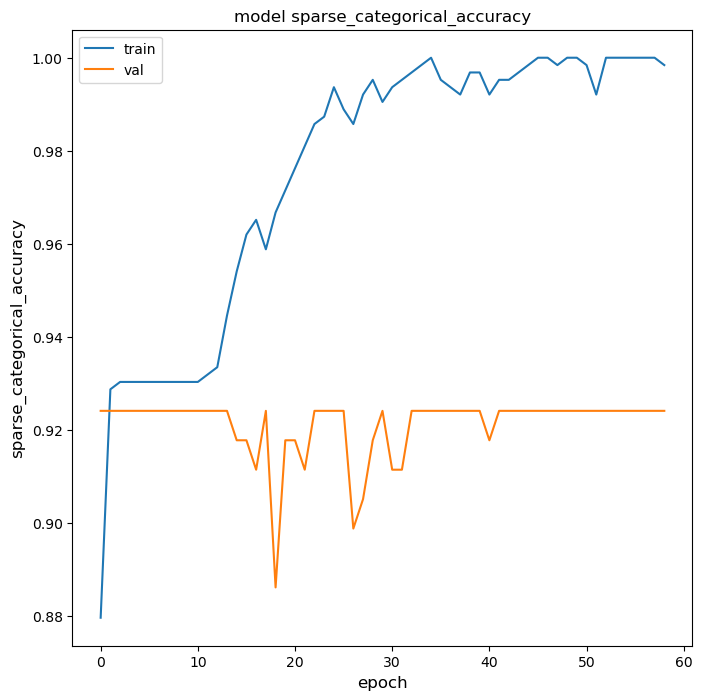

In [37]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

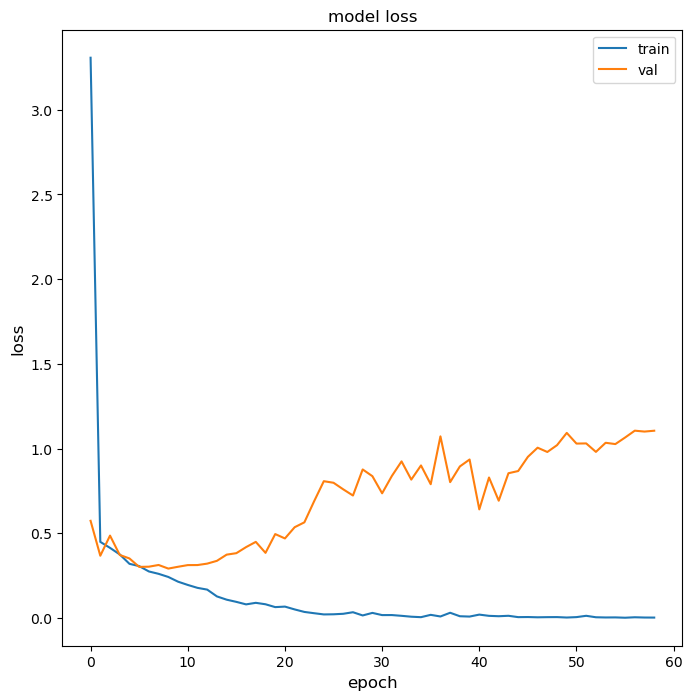

In [38]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

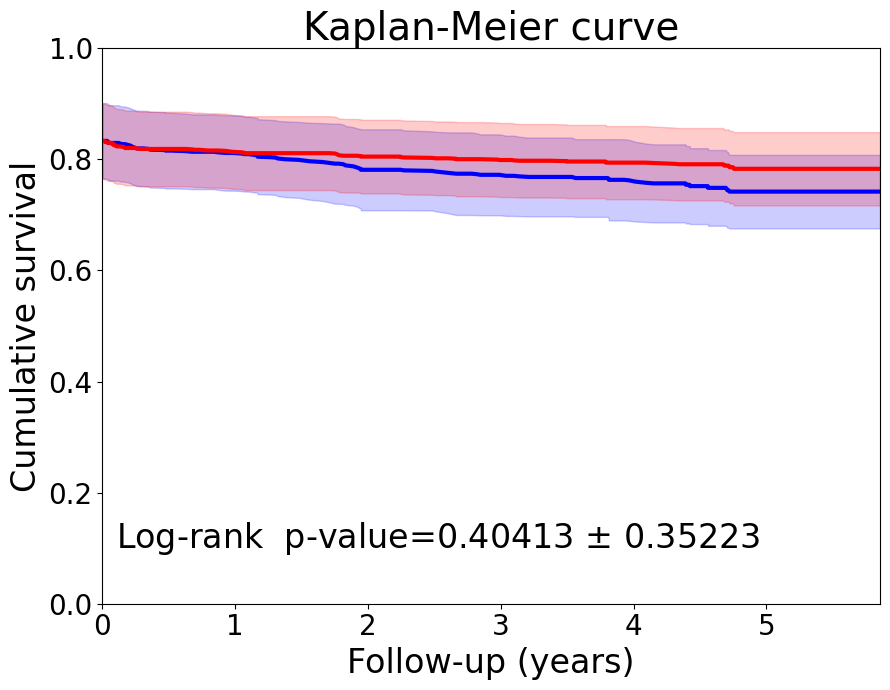

In [39]:
calculate_mean_KMcurve_SV[-1,:] = np.mean(calculate_mean_KMcurve_SV,axis=0)
calculate_mean_KMcurve_NS[-1,:] = np.mean(calculate_mean_KMcurve_NS,axis=0)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)

std_SV = np.std(calculate_mean_KMcurve_SV, axis=0, ddof=1)
std_NS = np.std(calculate_mean_KMcurve_NS, axis=0, ddof=1)

plt.fill_between(survival_time_sort, calculate_mean_KMcurve_SV[-1,:] + std_SV, calculate_mean_KMcurve_SV[-1,:] - std_SV, alpha=0.2, color='blue')
plt.plot(survival_time_sort, calculate_mean_KMcurve_SV[-1,:], color='blue', linewidth = 3.0, label='low risk')

plt.fill_between(survival_time_sort, calculate_mean_KMcurve_NS[-1,:] + std_NS, calculate_mean_KMcurve_NS[-1,:] - std_NS, alpha=0.2, color='red')
plt.plot(survival_time_sort, calculate_mean_KMcurve_NS[-1,:], color='red', linewidth = 3.0, label='high risk')

plt.title('Kaplan-Meier curve', fontsize=28)
plt.xticks(np.arange(0,survival_time_sort[-1],1))
plt.xlim(left=0, right=survival_time_sort[-1])
plt.ylim(bottom=0.0, top=1.0)
plt.xlabel('Follow-up (years)', fontsize=24)
plt.ylabel('Cumulative survival', fontsize=24)
plt.text(0.1, 0.1, 'Log-rank  p-value=%.5f $\pm$ %0.5f' % (np.mean(p_values), np.std(p_values)), fontsize=24)
plt.tick_params(labelsize = 20)

plt.tight_layout() 

plt.show()